#### Essayer d'apprendre les paramètres du ressort à partir des descripteurs des signaux pour avoir des coefs d'importance pour les descripteurs (poids à mettre pour le calcul des distance)

**Méthode utilisée:** regression linéaire sur un paramètre

In [22]:
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler 

import simu_ressort
import descriptor

In [71]:
names_desc = ['mean', 'std', 'fr_max', 'ampl_max', 'spectral centroid',
              'spectral width', 'spectral platitude', 'spectral asymetry']

In [24]:
dir_to_load = "data/lung_C"

In [59]:
files_to_load = os.listdir(dir_to_load)
all_simus = []

for file in files_to_load:
    data_df = pd.read_csv(dir_to_load + '/' + file)
    data_df = data_df[[col for col in data_df.columns if col[0] == 'V']]
    
    data_np = np.array(data_df).T
    
    # Cut data
    data_np = data_np[:, 25:]
    
    all_simus.append({
        'C': float(file[8:-4]),
        'simu': data_np
    })
    
print("Parameters C:")
print([x['C'] for x in all_simus])

Parameters C:
[0.0015, 0.001, 0.0025, 0.002, 0.0035, 0.003, 0.0045, 0.004, 0.0055, 0.005, 0.006]


In [54]:
all_simus[0]['simu'].shape

(100, 25)

-> 100 simus de taille 50

In [55]:
print("{} parameters tested, and {} simus for each parameter.".format(len(all_simus),
                                                                      all_simus[0]['simu'].shape[0]))
print("The duration of each simu is {} dt.".format(all_simus[0]['simu'].shape[1]))

print("{} descripteurs pour chaque simu".format(len(descriptor.compute_descriptor([1, 2]))))

11 parameters tested, and 100 simus for each parameter.
The duration of each simu is 25 dt.
8 descripteurs pour chaque simu


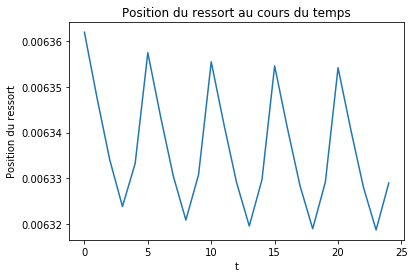

Descripteurs: [  6.33609687e-03   1.27312318e-05   0.00000000e+00   1.58402422e-01
   1.33054031e-21   1.70811282e-02   3.80176384e+02  -1.10048241e-15]


In [56]:
i = 6
V = all_simus[4]['simu'][i, :]
simu_ressort.plot_ressort(V)
desc = descriptor.compute_descriptor(V)
print("Descripteurs:", desc)

### Preprocess data

In [57]:
nb_desc = len(descriptor.compute_descriptor([0]))
nb_simus = len(all_simus) * len(all_simus[0]['simu'])
print("{} descriptors and {} signals".format(nb_desc, nb_simus))

D:\Cours\Ponts\MVA\ACTERREA\Code\acterrea\descriptor.py:8: RuntimeWarning: invalid value encountered in double_scalars
  sm = np.sum(fft*(freq**i))/np.sum(fft)


8 descriptors and 1100 signals


In [66]:
def preprocess_simu_to_numpy(all_simus, param='F'):

    X_data = []
    Y_data = []

    for i in range(len(all_simus)):
        for j in range(len(all_simus[i]['simu'])):
            X_data.append(descriptor.compute_descriptor(all_simus[i]['simu'][j, :]))
            Y_data.append([all_simus[i][param]])
            
    return np.array(X_data), np.array(Y_data)

In [67]:
def separate_test_train(X_data, Y_data, pct_train=0.8):
    n_train = int(pct_train * len(X_data))
    
    X_train = X_data[:n_train, :]
    X_test = X_data[n_train:, :]    
    Y_train = Y_data[:n_train, :]    
    Y_test = Y_data[n_train:, :]
    
    return X_train, X_test, Y_train, Y_test

In [90]:
X_data, Y_data = preprocess_simu_to_numpy(all_simus, param='C')

Y_data *= 100  # Sinon valuers de C trop faibles et coefs nuls

# Mettre les variables à la même échelle
X_data = StandardScaler().fit_transform(X_data)

print("Shape of X_data: {} and Y_data: {}".format(np.shape(X_data), np.shape(Y_data)))

X_train, X_test, Y_train, Y_test = separate_test_train(X_data, Y_data, pct_train=0.8)

Shape of X_data: (1100, 8) and Y_data: (1100, 1)


In [91]:
Y_data

array([[ 0.15],
       [ 0.15],
       [ 0.15],
       ..., 
       [ 0.6 ],
       [ 0.6 ],
       [ 0.6 ]])

In [92]:
# Transformer en DataFrame juste pour faire plus beau pour les coef de corr

X_df = pd.DataFrame(X_data)
X_df.columns = names_desc

# Ajouter les variables F et k
X_df['C'] = Y_data[:, 0]

X_df.describe()

,mean,std,fr_max,ampl_max,spectral centroid,spectral width,spectral platitude,spectral asymetry,C
count,1.100000e+03,1.100000e+03,1100.0,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1.100000e+03,1100.000000
mean,1.984271e-16,7.771561e-17,0.0,-7.339583e-16,-6.890952e-17,-1.117086e-15,2.503654e-15,-4.491357e-18,0.350000
std,1.000455e+00,1.000455e+00,0.0,1.000455e+00,1.000455e+00,1.000455e+00,1.000455e+00,1.000455e+00,0.158186
min,-1.815600e+00,-6.498936e-01,0.0,-1.815600e+00,-1.532652e+01,-9.618939e-01,-8.970470e-01,-5.340493e+00,0.100000
25%,-8.741132e-01,-5.843812e-01,0.0,-8.741132e-01,4.952577e-02,-7.556734e-01,-7.191513e-01,-4.411892e-01,0.200000
50%,1.439629e-01,-3.230515e-01,0.0,1.439629e-01,1.534090e-01,-1.985273e-01,-5.013917e-01,-9.889158e-02,0.350000
75%,8.848027e-01,2.720326e-01,0.0,8.848027e-01,1.876520e-01,3.374518e-01,4.343168e-01,3.886164e-01,0.500000
max,1.506292e+00,1.420072e+01,0.0,1.506292e+00,8.368993e+00,5.218994e+00,2.407814e+00,6.556128e+00,0.600000


## 1. Coefficients de corrélation

In [93]:
X_df.corr()

,mean,std,fr_max,ampl_max,spectral centroid,spectral width,spectral platitude,spectral asymetry,C
mean,1.000000,0.384400,NaN,1.000000,-0.067369,0.370715,-0.818530,-0.061060,0.987665
std,0.384400,1.000000,NaN,0.384400,-0.542882,0.863207,-0.476052,0.178590,0.440609
fr_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ampl_max,1.000000,0.384400,NaN,1.000000,-0.067369,0.370715,-0.818530,-0.061060,0.987665
spectral centroid,-0.067369,-0.542882,NaN,-0.067369,1.000000,-0.415668,0.139818,0.029950,-0.102731
spectral width,0.370715,0.863207,NaN,0.370715,-0.415668,1.000000,-0.646271,0.274857,0.421125
spectral platitude,-0.818530,-0.476052,NaN,-0.818530,0.139818,-0.646271,1.000000,-0.162407,-0.793639
spectral asymetry,-0.061060,0.178590,NaN,-0.061060,0.029950,0.274857,-0.162407,1.000000,-0.048114
C,0.987665,0.440609,NaN,0.987665,-0.102731,0.421125,-0.793639,-0.048114,1.000000


In [94]:
X_df.corr()['C']

mean                  0.987665
std                   0.440609
fr_max                     NaN
ampl_max              0.987665
spectral centroid    -0.102731
spectral width        0.421125
spectral platitude   -0.793639
spectral asymetry    -0.048114
C                     1.000000
Name: C, dtype: float64

`F` et `k` fortement corrélés à `spectrak width`mais également à `spectral platitude` et `spectral centroid`

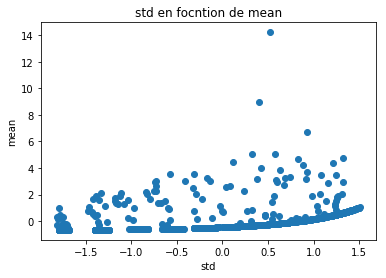

In [76]:
plt.scatter(X_data[:, 0], X_data[:, 1])
plt.title('std en focntion de mean')
plt.xlabel('std')
plt.ylabel('mean')
plt.show()

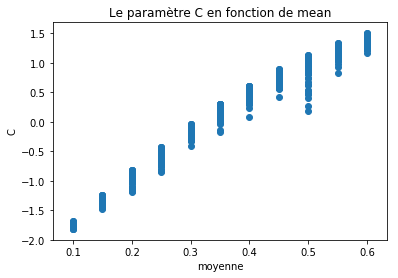

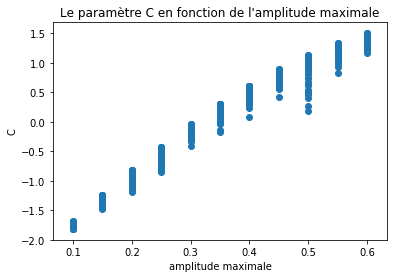

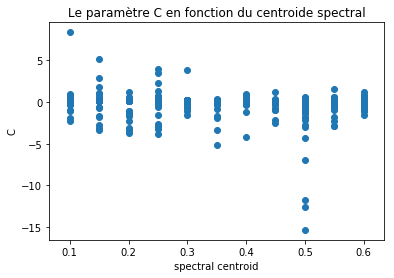

In [95]:
plt.scatter(Y_data[:, 0], X_data[:, 0])
plt.title('Le paramètre C en fonction de mean')
plt.xlabel('moyenne')
plt.ylabel('C')
plt.show()

plt.scatter(Y_data[:, 0], X_data[:, 3])
plt.title("Le paramètre C en fonction de l'amplitude maximale")
plt.xlabel('amplitude maximale')
plt.ylabel('C')
plt.show()

plt.scatter(Y_data[:, 0], X_data[:, 4])
plt.title("Le paramètre C en fonction du centroide spectral")
plt.xlabel('spectral centroid')
plt.ylabel('C')
plt.show()

## 2. Apprendre `C` avec une regression linéaire
Pour trouver les poids des descripteurs

In [96]:
def train_regr_lin(X_train, Y_train, X_test, Y_test):
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)

    y_pred = regr.predict(X_test)
    print("MSE on test set:", mean_squared_error(y_pred, Y_test))
    
    return regr

In [97]:
_ = train_regr_lin(X_train, Y_train, X_test, Y_test)

MSE on test set: 0.00134227216263


-> L'erreur est assez variable selon le jeu de données et j'ai du mal à voir pourquoi

#### Prédiction de `C`

In [100]:
regr_f = train_regr_lin(X_train, Y_train[:, 0], X_test, Y_test[:, 0])

MSE on test set: 0.00134227216263


In [101]:
regr_f.coef_

array([  8.43937872e-02,  -1.34453259e-02,   6.93889390e-18,
         8.43937872e-02,   3.93473117e-04,   2.94654269e-02,
         2.96960844e-02,   2.02338753e-03])

In [103]:
def normalize_coef(coefs, seuil=0.005):
    coefs_treated = [abs(x) for x in coefs]
    coefs_treated = [x if x > seuil else 0 for x in coefs_treated]
    
    # Somme = 1
    print(np.sum(coefs_treated))
    coefs_treated /= np.sum(coefs_treated)

    # Mettre dans un dico pour faire joli
    coefs_dico = {}
    for i in range(len(coefs_treated)):
        coefs_dico[names_desc[i]] = coefs_treated[i]
    
    return coefs_dico, coefs_treated
    
coefs_dico, coefs_treated = normalize_coef(regr_f.coef_)
print(coefs_treated)
coefs_dico

0.24139441165
[ 0.34960953  0.05569858  0.          0.34960953  0.          0.12206342
  0.12301894  0.        ]


{'ampl_max': 0.34960953174918369,
 'fr_max': 0.0,
 'mean': 0.34960953174918391,
 'spectral asymetry': 0.0,
 'spectral centroid': 0.0,
 'spectral platitude': 0.12301893906475682,
 'spectral width': 0.1220634177320702,
 'std': 0.055698579704805427}

In [104]:
regr_f.intercept_  # Zero à l'origine

0.34463956984754979

## 3. ACP

In [105]:
from sklearn.decomposition import PCA

In [106]:
from sklearn import preprocessing

# Normalize data

scaler = preprocessing.StandardScaler().fit(X_data)
X_scaled = preprocessing.scale(X_data)

#### Projection en 2D

In [107]:
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data=principal_comp, columns=['principal component 1', 'principal component 2'])
principal_df['target'] = Y_data[:, 0]

In [108]:
x = pca.explained_variance_ratio_
print(x)
print("La premiere composante principale explique {}% de la variance des données".format(round(x[0] * 100, 2)))

[ 0.51372346  0.22806295]
La premiere composante principale explique 51.37% de la variance des données


In [109]:
pca.components_

array([[ 0.44258638,  0.40408794, -0.        ,  0.44258638, -0.19908908,
         0.41873049, -0.47307121,  0.07860966],
       [-0.40511537,  0.41084634,  0.        , -0.40511537, -0.48627898,
         0.37516416,  0.18036928,  0.30531931]])

-> Coordonnées des premières et deuxiemes composantes principales dans l'espace des descripteurs

ACP pour faire de la réduction de dimension: projetter sur un certains nb de composantes principales (nb < au nb de coord)

**Problème de l'ACP:** la moyenne, variance, etc... sont les variables qui permettent le mieux d'"étaler" les points alors qu'elles ne sont pas pertinentes ici, car le but est de classifier en fonction de F et k

-> Utile en non supervisé lorque l'on a vraiment aucune idée de ce que l'on cherche